Give a go at building a very basic autoencoder to reconstruct spectra.  Then see if the latent parameters are useful at separating any physical properties of the quasars.

Note that a *Variational* autoencoder is what we want to end up at.  The encoder would return latent *distributions* in the latent space; instead of simply reducing the spectra to say 6 latent values, it would return a "latent mean" and "latent variance" for each dimension in latent space.  Then, the decoder would randomly draw from each of these distributions to reconstruct the spectra.  Thus, a variational autoencoder is non-deterministic.

In [1]:
from tensorflow import keras

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import richardsplot
import os

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
#Load the metadata of all 8403 objects
dat = pd.read_csv("../data/grdr7.8403col.radec.platemjdfiber.csv")
dat.head()

,name,RA_1,Dec_1,RA_2,DEC_2,REDSHIFT,PLATE,FIBER,MJD
0,095004.94-002012.2,147.520612,-0.336744,147.520615,-0.336744,1.7756,267,275,51608
1,095938.28-003500.8,149.909527,-0.583571,149.909531,-0.583571,1.8766,268,59,51633
2,101033.44-004724.5,152.639355,-0.790145,152.639359,-0.790145,1.6675,270,213,51909
3,101100.92+002039.4,152.753859,0.344291,152.753860,0.344291,1.7487,270,491,51909
4,101826.85-000951.1,154.611911,-0.164201,154.611908,-0.164201,1.8156,271,152,51883


In [3]:
z     = dat[["REDSHIFT"]].values.flatten()
plate = dat[["PLATE"]].values.flatten()
mjd   = dat[["MJD"]].values.flatten()
fiber = dat[["FIBER"]].values.flatten()

This cell can take a while.

In [4]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
spectra = np.array([])
wave    = np.array([])
ivar    = np.array([])
N = 0

for red, pl, mj, fib in zip(z, plate, mjd, fiber):
    try:
        hdul_spec = fits.open("../data/VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        print("../data/VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>1470) & (sdss_wave<2875))
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(spectra) < 1:
        spectra = np.append(spectra, sdss_flux)
        wave = np.append(wave, sdss_wave)
        ivar = np.append(ivar, sdss_ivar)
    else:
        if len(sdss_flux) >= 2913:
            spectra = np.vstack((spectra, sdss_flux[:2913])) #Some might have one extra pixel
            wave = np.vstack((wave, sdss_wave[:2913]))
            ivar = np.vstack((ivar, sdss_ivar[:2913]))
            
    N+=1
    if N>1000: break #Just because this cell takes a while to run and we don't need all spectra since we're not deriving our own components 

----

Now build the autoencoder.  See Chapter 17 of Geron, Hands-on Machine Learning...

In [5]:
spectra[0].shape

(2913,)

In [6]:
#Build the encoder - the dimension of the final layer is the dimension of the latent space
stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=spectra[0].shape),
    keras.layers.Dense(300, activation="selu"),
    keras.layers.Dense(50, activation="selu")
])

#Build the decoder - given values in latent space, it will reconstruct the original spectrum
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(300, activation="selu", input_shape=[50]),
    keras.layers.Dense(spectra[0].shape[0]) #no activation function since we want actual pixel values
])

#Now put them together
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

Now need to compile our model.  The two main ingredients will be the loss function we choose, and the optimizer.  Keep it simple for now, and just see what happens with mean square error and stochastic gradient descent.

In [7]:
stacked_ae.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [8]:
spectra.shape

(1001, 2913)

In [9]:
X_train = spectra[:800]
X_valid = spectra[800:]

#X_train will be both the "input" (to the encoder) and the "target" (of the decoder) for the autoencoder
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 800 samples, validate on 201 samples
Epoch 1/10
800/800 [==============================] - 2s 2ms/sample - loss: 133.1014 - val_loss: 4.2650
Epoch 2/10
800/800 [==============================] - 1s 722us/sample - loss: 79.3519 - val_loss: 137.4711
Epoch 3/10
800/800 [==============================] - 1s 736us/sample - loss: 24.1277 - val_loss: 4.6782
Epoch 4/10
800/800 [==============================] - 1s 731us/sample - loss: 34.9617 - val_loss: 4.1721
Epoch 5/10
800/800 [==============================] - 1s 722us/sample - loss: 22.1898 - val_loss: 3.9487
Epoch 6/10
800/800 [==============================] - 1s 736us/sample - loss: 5.7225 - val_loss: 3.9651
Epoch 7/10
800/800 [==============================] - 1s 733us/sample - loss: 5.6547 - val_loss: 4.2624
Epoch 8/10
800/800 [==============================] - 1s 730us/sample - loss: 5.5582 - val_loss: 4.1976
Epoch 9/10
800/800 [==============================] - 1s 759us/sample - loss: 5.1712 - val_loss: 3.9023
Epoch 10/10


Now visualize some of the reconstructions...how bad are they?

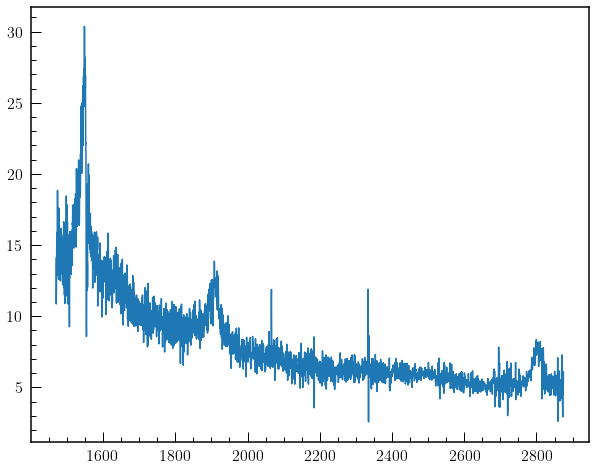

In [10]:
fig = plt.figure(figsize=(10,8))

plt.plot(wave[800], spectra[800])

plt.show()

In [17]:
reconst = stacked_ae.predict(np.array([X_valid[0]]))

In [18]:
reconst[0]

array([12.584504 , 12.620133 , 12.192705 , ...,  5.5886126,  5.2495375,
        5.4273233], dtype=float32)

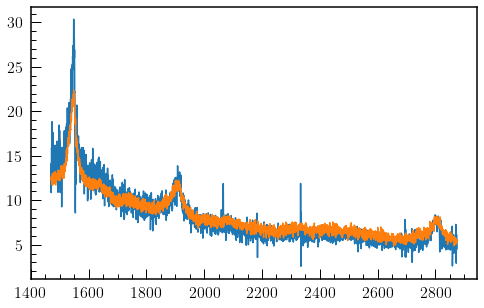

In [20]:
fig = plt.figure(figsize=(8,5))

#plt.plot(wave[800], spectra[800])
plt.plot(wave[801], X_valid[0])
plt.plot(wave[800], reconst[0])
plt.show()

Not perfect, but pretty good considering I really didn't put any thought into the hyperparameters and we only spent 10 epochs training!  Keep this notebook simple, so I'll shift to another to see if we can do a better job of reconstructing with a lower-dimensional latent space (currently, N=50).

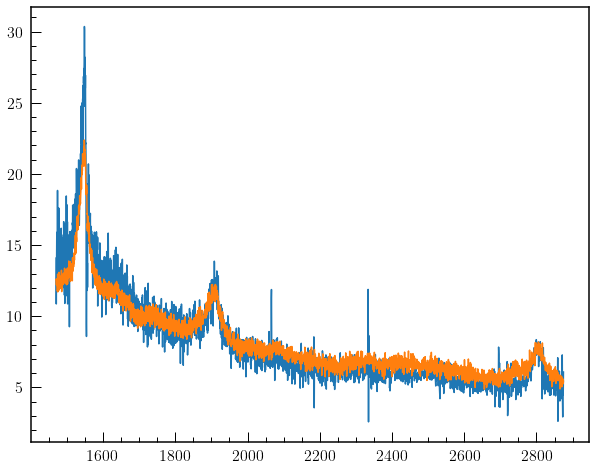

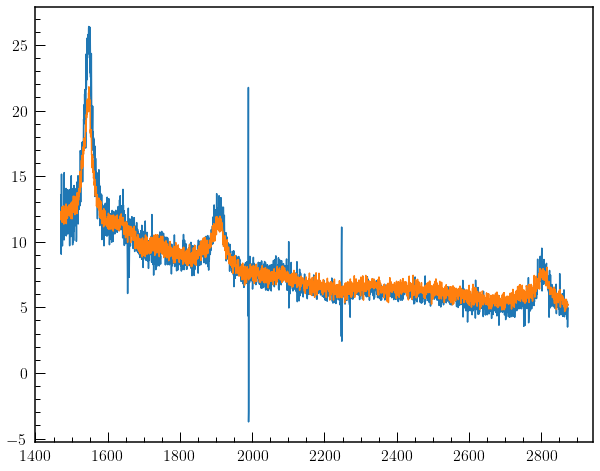

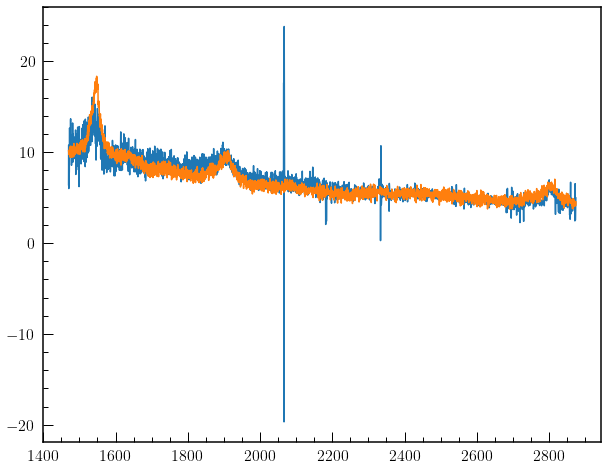

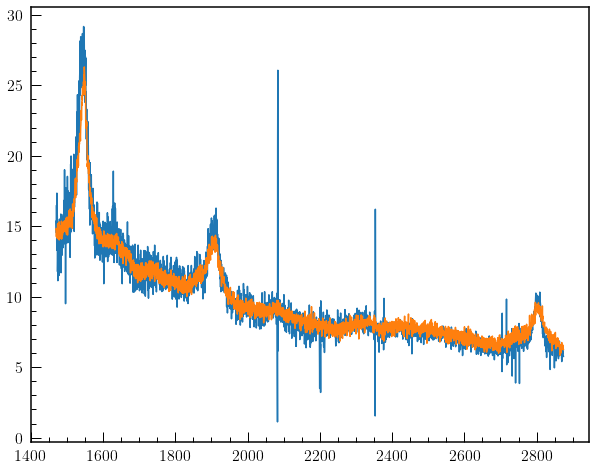

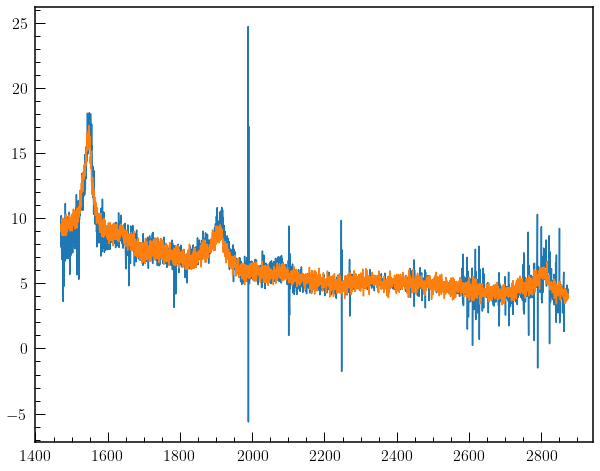

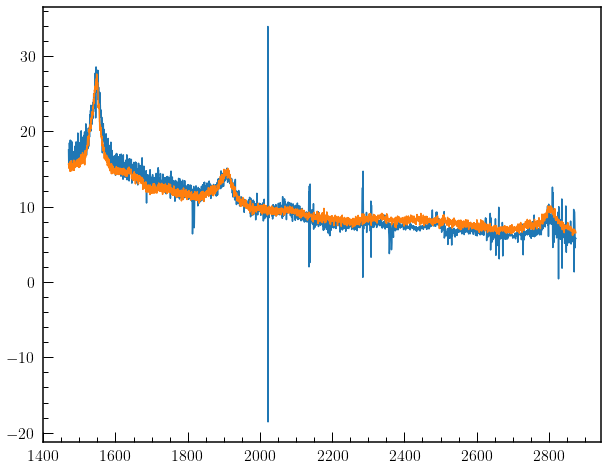

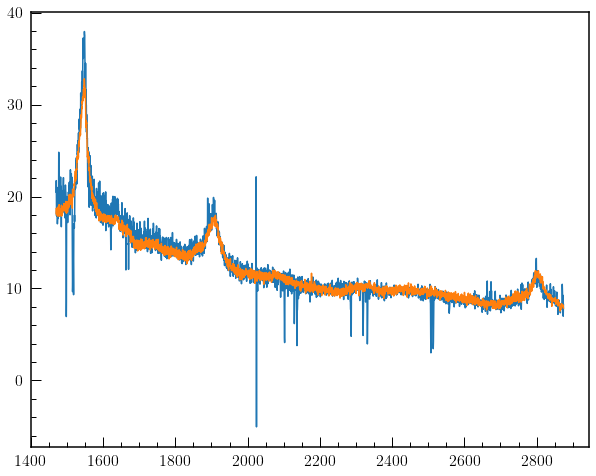

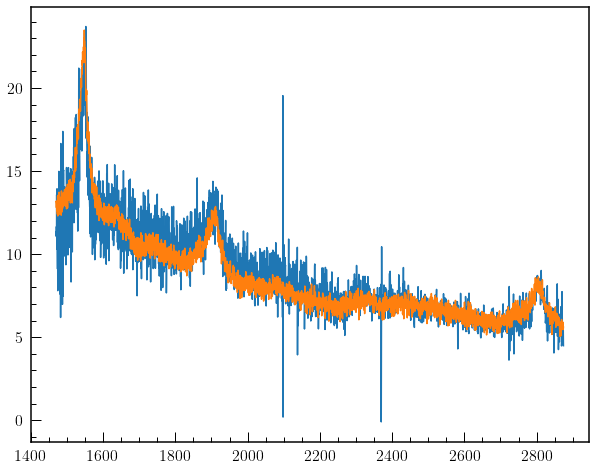

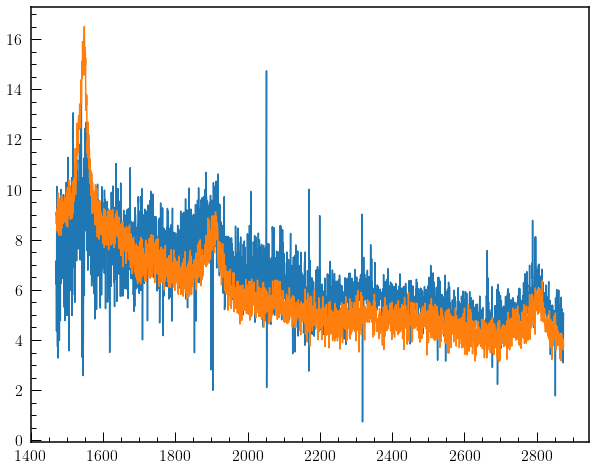

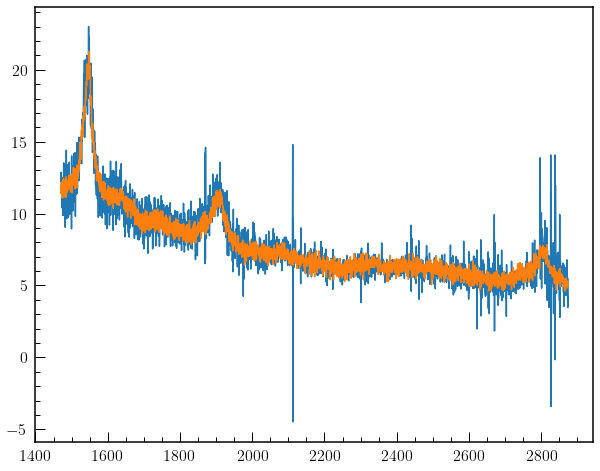

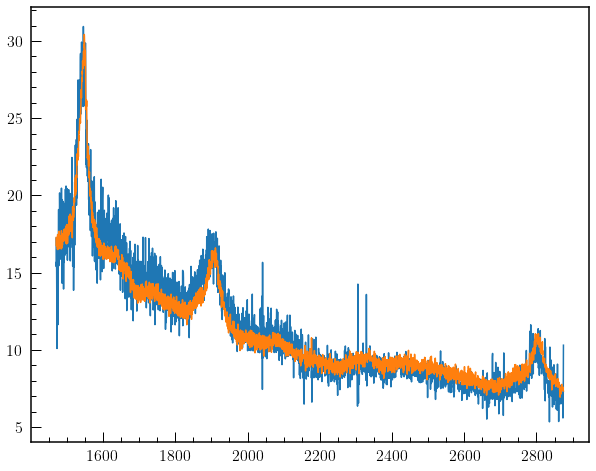

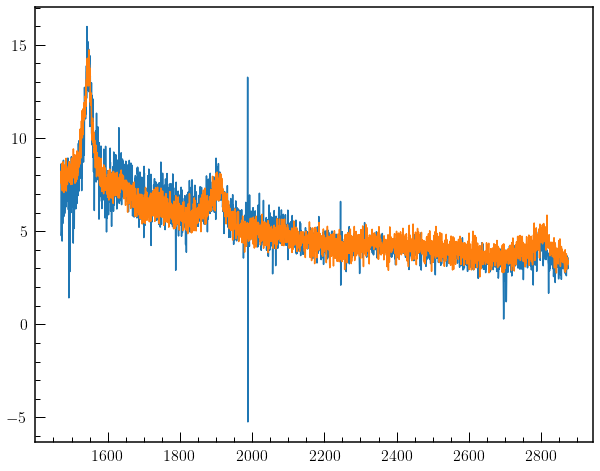

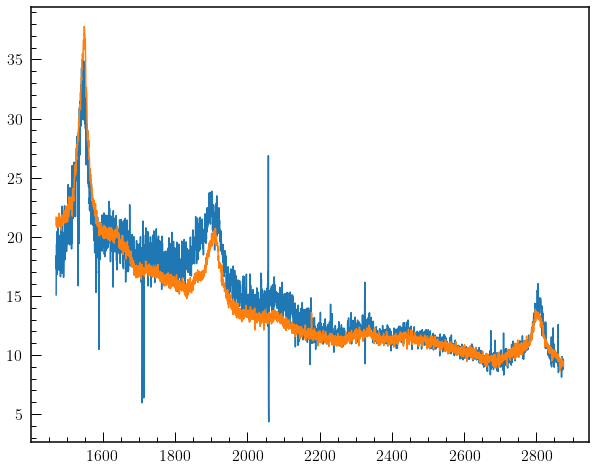

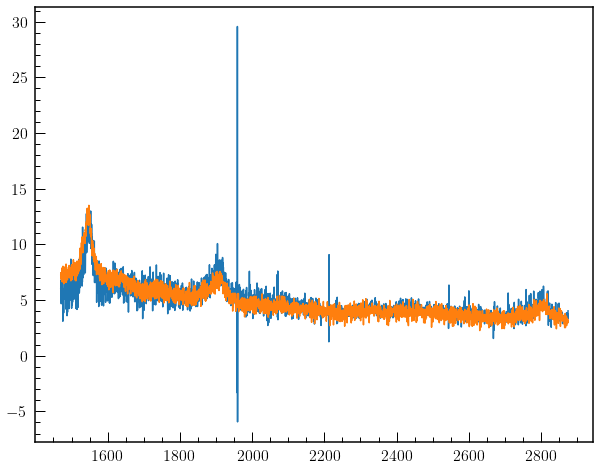

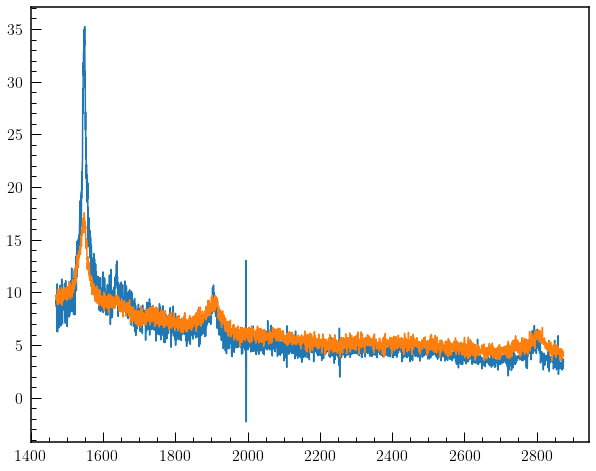

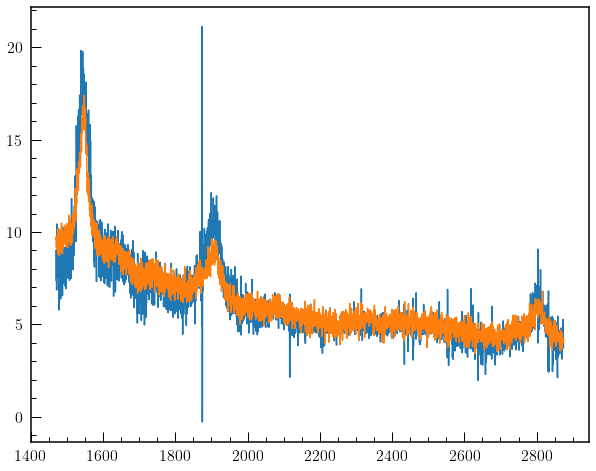

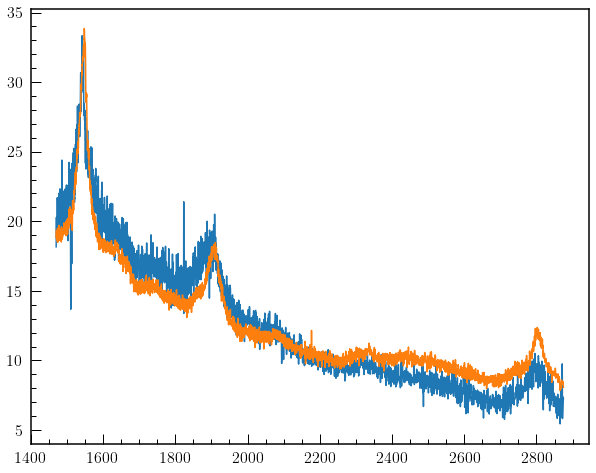

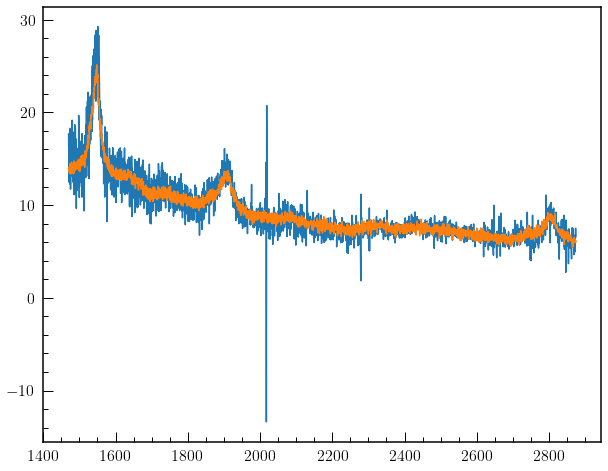

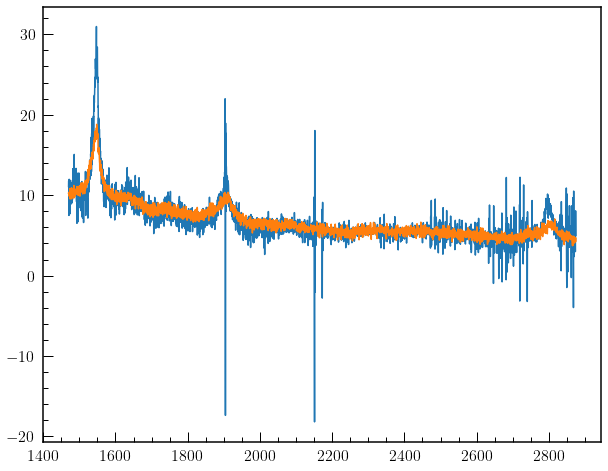

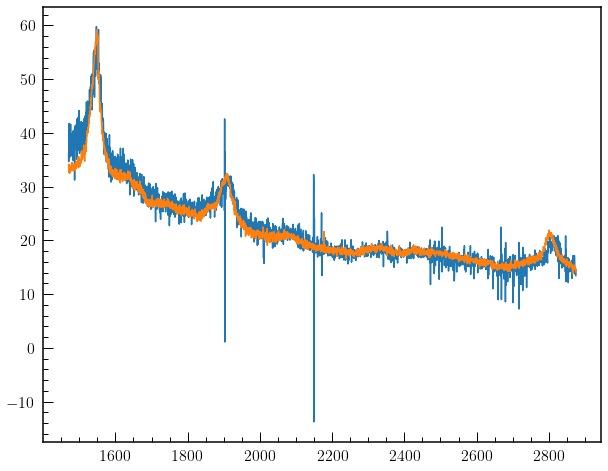

In [21]:
n_spectra = 20
for i in range(n_spectra):
    reconst = stacked_ae.predict(np.array([X_valid[i]]))
    fig = plt.figure(figsize=(10,8))
    plt.plot(wave[800+i], X_valid[i])
    plt.plot(wave[800+i], reconst[0])
    plt.show()

Looks like it definitely struggles with objects with larger/smaller EWs, but hopefully that can be remedied with more training.